In [1]:
import torch
from torchvision.transforms import RandomCrop, Resize
from PIL import Image
from sklearn.datasets import fetch_lfw_people
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from datasets.dataset import DatasetFromFolder

In [3]:
ds = DatasetFromFolder("data/div2k/train")

In [4]:
data_loader = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    pin_memory=True,
    batch_size=16,
    num_workers=4)

In [ ]:
from utils.visualization import visualize_images

In [ ]:
images = [ds[i] for i in range(3)]

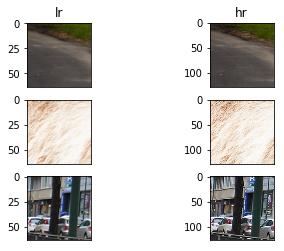

In [ ]:
images = [ds[i] for i in range(3)]
visualize_images(("lr", "hr"), *images)

In [ ]:
dataset = fetch_lfw_people(data_home="faces", color=True)
# pairs_generator()

In [ ]:
data, images = dataset["data"], dataset["images"]
n = data.shape[0]
images.shape

In [ ]:
plt.imshow(Image.fromarray(images[0].astype("uint8"), "RGB"));

In [ ]:
def pairs_generator(to_torch=False):
    bigcropper = RandomCrop(size=(40,40))
    resizer = Resize(size=(20,20))
    
    for image in map(lambda img: Image.fromarray(np.array(img, dtype=np.uint8)), images):
        big = bigcropper(image)
        small = resizer(big)
        if to_torch:
            yield tuple(map(lambda img: torch.from_numpy(np.array(img)), (small, big)))       
        else:
            yield tuple(map(np.array, (small, big)))    

In [ ]:
def raw_batch_generator(batch_size=32):
    generator = pairs_generator(to_torch=True)
    for i in range(n//batch_size):
        yield [next(generator) for i in range(batch_size)]

def images_and_labels_generator(batch_size=32):
    for batch in raw_batch_generator(batch_size):
        images, labels = [], []
        for (small, big) in batch:
            images.append(small.float())
            labels.append(big.float())
        
        batch_images = torch.stack(images, dim=0).permute(0, 3, 2, 1)
        batch_labels = torch.stack(labels, dim=0).permute(0, 3, 2, 1)
        yield batch_images, batch_labels

In [ ]:
data.shape

In [ ]:
x, y = next(images_and_labels_generator())

In [ ]:
plt.imshow(x[0, 2, :, :])
# x.shape

In [ ]:
nrows, ncols = (3,2)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
for i, (small, big) in enumerate(pairs_generator()):
    ax1, ax2 = axs[i]
    ax1.imshow(small, cmap=plt.cm.gray)
    ax2.imshow(big, cmap=plt.cm.gray)
    if i + 1 >= nrows:
        break

In [ ]:
from torch import nn
class Net(nn.Module):
    def __init__(self, upscale):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
#         self.batch_norm = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(3, 64, (5, 5), padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv21 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv22 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), padding=(1, 1))
        self.conv4 = nn.Conv2d(32,  32**upscale, (3, 3), padding=(1,1))
        self.pixel_shuffle1 = nn.PixelShuffle(upscale)
        self.conv5 = nn.Conv2d(256, 3, (3,3), padding=(1,1))
        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle1(self.conv4(x))
        x = self.conv5(x)
        return x

    def _initialize_weights(self):
        init = nn.init
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)
        init.orthogonal_(self.conv5.weight)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
net = GenNet(upscale=2).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), amsgrad=True)

In [ ]:
x.shape

In [ ]:
# net.forward(x.to(device)).shape
z = net.forward(x.to(device)).cpu().detach()[0, 0, :, :]
plt.imshow(z)

In [ ]:
z.shape, y[0,0,:,:].shape

In [ ]:
def psnr(mse): 
    return - 10 * np.log10(mse)

In [ ]:
errs, metrics = list(), list()
for epoch in range(10):
    print("Epoch {} started".format(epoch))
    net.train()
    for i, (data, target) in enumerate(images_and_labels_generator(64)):
        
        batch_features = data.to(device)
        batch_labels = target.to(device)
        
        batch_preds = net.forward(batch_features)

        optimizer.zero_grad()
        loss = torch.log10(criterion(batch_preds, batch_labels))
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            err = loss.item()
            metric = psnr(criterion(batch_preds, batch_labels).detach().cpu().numpy())
            errs.append(err)
            metrics.append(metric)
            print("Batch {} loss {}, ".format(i, err), end=" ")
            print("psnr: {}".format(metric))

In [ ]:
pred, answ = net.forward(x.to(device)).cpu().detach()[0], y[0]

In [ ]:
nrows, ncols = (2,3)
pred, answ = net.forward(x.to(device)).cpu().detach()[0:nrows].permute(0, 3, 2, 1), y[0:nrows].permute(0, 3, 2, 1)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
for i, (prd, ans) in enumerate(zip(pred, answ)):
    ax1, ax2, ax3 = axs[i]
    resizer = Resize(size=(40,40), interpolation=3)
    img = Image.fromarray(x[i].numpy().astype("uint8").swapaxes(0, 2), "RGB")
    ax1.imshow(resizer(img))
    ax1.set_title("Basic resize")
    ax2.imshow(prd / 255)
    ax2.set_title("Prediction")
    ax3.imshow(ans / 255)
    ax3.set_title("Answer")
    if i + 1 >= nrows:
        break